In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize

In [2]:
p_s = 100000 #Pa
p_t = 10000 #Pa
cp_air = 1000 #J kg-1 K-1
g = 10 #m s-2
Ra = 287 #J kg-1 K-1 air
Rv = 461 #J kg-1 K-1 water vapor
Lv = 2.3E6 #J kg-1
eps = Ra/Rv #dimensionless


lapse_dry = -g/cp_air #K/m 
lapse_moist = -5

In [3]:
def w_sat_p(T): #Pa
    e_sat = 610.94 * np.exp(-Lv/Rv*(1/T-1/273.15))
    return e_sat

def w_sat_mix(T,p): #kg/kg
    r_sat = eps*w_sat_p(T)/p
    return r_sat

def MALR(T,p): #dlnT/dlnp
    r_sat = w_sat_mix(T,p)
    A = (Lv*r_sat)/(Ra*T)
    B = (Lv**2*r_sat)/(cp_air*Ra*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_s,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_s
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Ra/g * lapse_z
    return l_p


def T_atm_z(T_s,z,lapse_z):
    Temp = T_s + z*lapse_z
    return Temp

def T_atm_p(T_s,p,lapse_p):
    Temp = T_s * (p/p_s)**(lapse_p)
    return Temp
    

def height(p,T): #m
    rho = p/(Ra*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def TE(T): #J kg-1
    energy = integrate.trapezoid(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z): #J kg-1
    energy = integrate.trapezoid(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapezoid(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def TE_moist_opt(T_s): #the pressure array is external, meaning is not an optimisation parameter (i.e., won't be changed) 
    T_moist = T_MA(T_s,p)
    thermal_energy = TE(T_moist)
    return thermal_energy

def T_surface(thermal_energy):
    def fun(x):
        res = TE_moist_opt(x)-thermal_energy
        return res
        
    T_surface = optimize.root_scalar(fun, bracket=[230,330])
    return T_surface.root

def water_mass(energy):#kg m-2
    mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv * mass_atm
    return mass_w

[100000.          92367.08571874  85316.78524173  78804.6281567
  72789.53843983  67233.57536499  62101.69418916  57361.52510449
  52983.16906284  48939.00918477  45203.5365636   41753.1893656
  38566.20421163  35622.47890262  32903.44562313  30391.95382313
  28072.16203941  25929.43797405  23950.26619987  22122.1629107
  20433.59717857  18873.91822135  17433.288222    16102.62027561
  14873.52107294  13738.23795883  12689.61003168  11721.02297533
  10826.36733874  10000.        ]


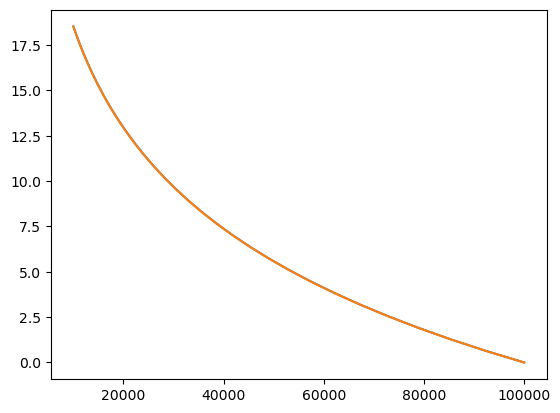

In [4]:
n_lev = 30
p = np.logspace(5,4,n_lev)
print(p)
#p = np.linspace(p_s,p_t,n_lev)
T = np.ones((n_lev))*280
z = height(p,T)

plt.plot(p,z/1000)
plt.plot(p_s*np.exp(-g*z/(Ra*280)),z/1000)
plt.show()

water mass and dry static energy differences between moist and dry
-0.720894366618013
-184.22856035793666
dry static energy difference between moist and isothermal
1630.922515275539


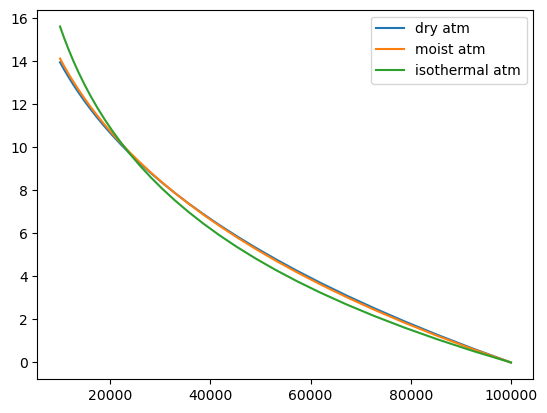

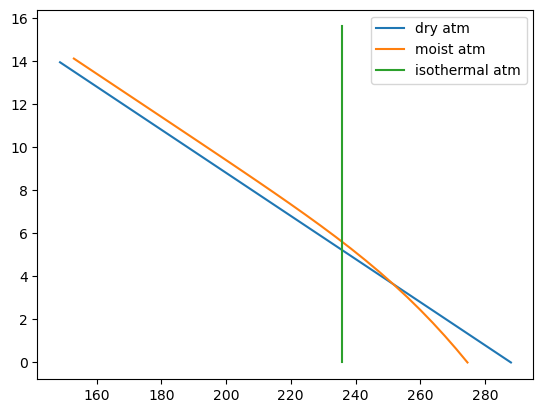

In [5]:
n_lev = 30
T_s = 288
#p = np.linspace(p_s,p_t,n_lev)
lapse_p = lapse_pressure(lapse_dry)
T = T_atm_p(288,p,lapse_p)
z = height(p,T)

T_s = T_surface(TE(T))

T_moist = T_MA(T_s,p)
z_moist = height(p,T_moist)

T_eq = TE(T_moist)/(cp_air)
T_iso = np.ones((n_lev))*T_eq
z_iso = height(p,T_iso)

TE_diff = TE(T_moist)-TE(T)
DSE_diff = DSE(T_moist,z_moist)-DSE(T,z)
print('water mass and dry static energy differences between moist and dry')
print(water_mass(DSE_diff))
print(DSE_diff)

print('dry static energy difference between moist and isothermal')
print(DSE(T_moist,z_moist)-DSE(T_iso,z_iso))
    
plt.plot(p,z/1000, label='dry atm')
plt.plot(p,z_moist/1000, label = 'moist atm')
plt.plot(p,z_iso/1000, label = 'isothermal atm')
plt.legend()
plt.show()
plt.plot(T,z/1000, label = 'dry atm')
plt.plot(T_moist,z_moist/1000, label = 'moist atm')
plt.plot(T_iso,z_iso/1000, label = 'isothermal atm')
plt.legend()
plt.show()

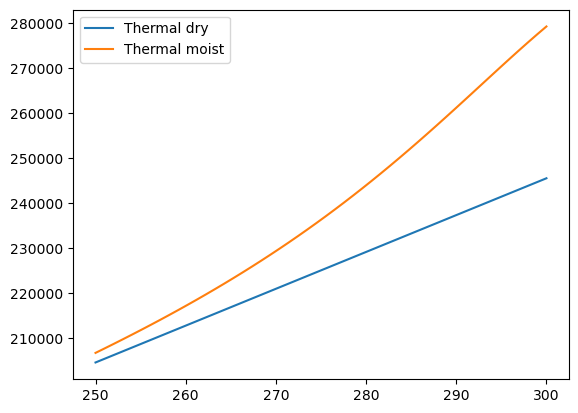

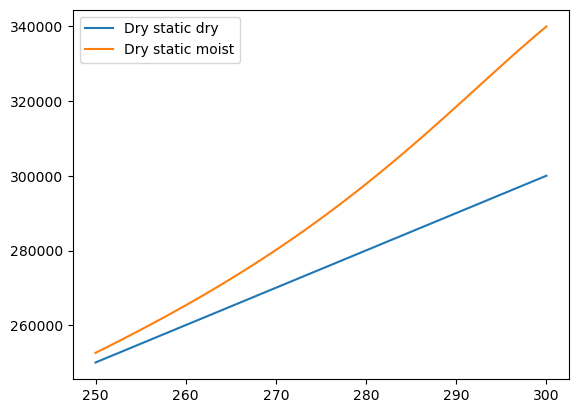

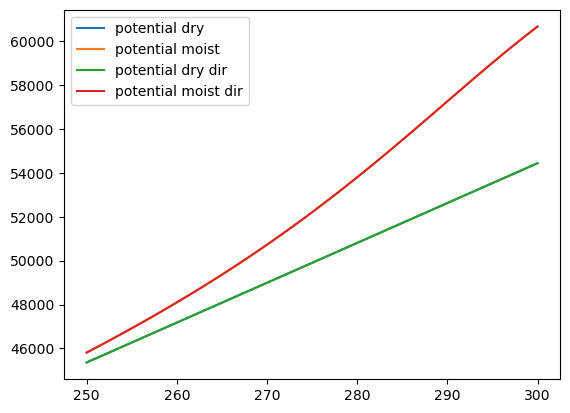

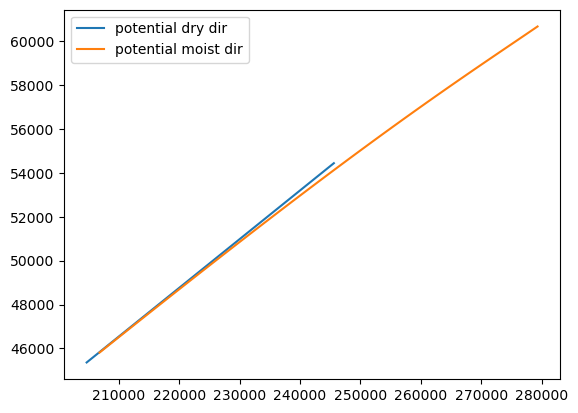

In [6]:
T_s = np.linspace(250,300,50)
E_dry_T = np.zeros((len(T_s)))
E_moist_T = np.zeros((len(T_s)))
DE_dry = np.zeros((len(T_s)))
DE_moist = np.zeros((len(T_s)))
PE_dry = np.zeros((len(T_s)))
PE_moist = np.zeros((len(T_s)))

for i in range(len(T_s)):
    T_moist = T_MA(T_s[i],p)
    T_dry = T_atm_p(T_s[i],p,lapse_p)

    z_moist = height(p,T_moist)
    z_dry = height(p,T_dry)
    
    E_dry_T[i] = TE(T_dry)
    E_moist_T[i] = TE(T_moist)

    PE_dry[i] = PE(z_dry)
    PE_moist[i] = PE(z_moist)
    
    DE_dry[i] = DSE(T_dry,z_dry)
    DE_moist[i] = DSE(T_moist,z_moist)

plt.plot(T_s,E_dry_T,label='Thermal dry')
plt.plot(T_s,E_moist_T,label='Thermal moist')
plt.legend()
plt.show()

plt.plot(T_s,DE_dry,label='Dry static dry')
plt.plot(T_s,DE_moist,label='Dry static moist')
plt.legend()
plt.show()

plt.plot(T_s,DE_dry-E_dry_T,label='potential dry')
plt.plot(T_s,DE_moist-E_moist_T,label='potential moist')
plt.plot(T_s,PE_dry,label='potential dry dir')
plt.plot(T_s,PE_moist,label='potential moist dir')
plt.legend()
plt.show()

plt.plot(E_dry_T,PE_dry,label='potential dry dir')
plt.plot(E_moist_T,PE_moist,label='potential moist dir')
plt.legend()
plt.show()
